# Models

Three models.

1. travel time ~ travel distance + road attributes. [i,j]
2. mobility flow ~ origin attributes + destination attributes + travel time
3. income ~ mobility flow (aggregate for origin or destination, or not?)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import pickle
import geoplot.crs as gcrs
import statsmodels.api as sm

/home/jasonllu/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.9.0-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# read two datasets
edge_df = pd.read_pickle('../../data_process/edge_specific_df.pickle')
node_df = pd.read_pickle('../../data_process/node_specific_df.pickle')
node_degree_df = pd.read_pickle('../../data_process/node_degree_df.pickle')
edge_degree_df = pd.read_pickle('../../data_process/edge_degree_df.pickle')

In [3]:
print(edge_df.shape)
print(node_df.shape)
print(edge_degree_df.shape)
print(edge_df.columns)
print(node_df.columns)
print(edge_degree_df.columns)
print(node_degree_df.columns)

(10240, 27)
(103, 42)
(10240, 39)
Index(['timestamp', 'destination', 'state', 'origin', 'unique_agents',
       'sum_stay_duration', 'total_stays', 'OD', 'class_ART', 'class_BUS',
       'class_COLL', 'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA',
       'class_TRK2', 'class_TRK4', 'class_UND', 'num_jobs_000_persons_origin',
       'sa2_code16_x', 'median_income_per_job_aud_origin',
       'num_jobs_000_persons_destination', 'sa2_code16_y',
       'median_income_per_job_aud_destination', 'od_duration_value',
       'od_distance_value', 'road_counts'],
      dtype='object')
Index(['SA2_MAIN16', 'SA2_5DIG16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16',
       'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'GCC_NAME16', 'STE_CODE16',
       'STE_NAME16', 'AREASQKM16', 'class_ART', 'class_BUS', 'class_COLL',
       'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA', 'class_TRK2',
       'class_TRK4', 'class_UND', 'geometry', 'num_jobs_000_persons',
       'sa2_code16', 'median_income_p

In [4]:
edge_degree_df.head()

,timestamp,destination,state,origin,unique_agents,sum_stay_duration,total_stays,OD,class_ART,class_BUS,...,num_2degree_x,num_3degree_x,num_4degree_x,num_greater5degree_x,num_nodes_y,num_1degree_y,num_2degree_y,num_3degree_y,num_4degree_y,num_greater5degree_y
0,2018-02-01T00:00:00.000+11:00,401011001,4,401011001,19863,268779414,681217,401011001401011001,208.0,13.0,...,199.0,865.0,276.0,11.0,1642.0,291.0,199.0,865.0,276.0,11.0
1,2018-02-01T00:00:00.000+11:00,401011002,4,401011001,6911,4857456,29322,401011001401011002,267.0,16.0,...,199.0,865.0,276.0,11.0,517.0,149.0,54.0,239.0,69.0,6.0
2,2018-02-01T00:00:00.000+11:00,401021003,4,401011001,404,253764,1334,401011001401021003,838.0,82.0,...,199.0,865.0,276.0,11.0,4034.0,1174.0,731.0,1982.0,141.0,6.0
3,2018-02-01T00:00:00.000+11:00,401021004,4,401011001,1184,903377,5487,401011001401021004,430.0,13.0,...,199.0,865.0,276.0,11.0,2455.0,710.0,502.0,1126.0,110.0,7.0
4,2018-02-01T00:00:00.000+11:00,401021005,4,401011001,700,189721,1278,401011001401021005,517.0,13.0,...,199.0,865.0,276.0,11.0,989.0,286.0,245.0,421.0,36.0,1.0


## Model 1 - Travel Time

In [5]:
def combination(nums, k):
    res = []
    nums.sort()
    def dfs(A, path):
        if len(path) == k:
            res.append(path[:])
            return
        #even faster, you can just do while A and popleft, rather than copying B, as for the dup check, just keep track of a prev
        for i, elt in enumerate(A):
            if i-1 >= 0 and elt == A[i-1]:
                continue
            path.append(elt)
            dfs(A[i+1:], path)
            path.pop()
    dfs(nums,[])
    return res

In [6]:
def latex_table(all_vars, models):
    errors = []
    for elt in all_vars:
        e = elt + "_err"
        errors.append(e)
    temp = []
    for i in range(len(all_vars)):
        temp.append(all_vars[i])
        if all_vars[i] not in {'Observations','R_squared', 'Adjusted_R_squared'}:
            temp.append(errors[i])

    table1 = pd.DataFrame(columns=temp)
    for variables,data, model in models:
        dict = {}
        for i, elt in enumerate(all_vars):
            if elt in model.params:
                i = list(model.params.keys()).index(elt)
                pval = model.pvalues[i]
                tag = ""
                if pval < 0.001:
                    tag = "***"
                elif pval < 0.01:
                    tag = "**"
                elif pval < 0.05:
                    tag = "*"
                dict[elt] = str(round(model.params[elt], 3)) + tag
                dict[elt+"_err"] = "(" + str(round(model.bse[elt], 3)) + ")"
            else:
                dict[elt] = "" 
                if elt not in {'Observations', 'R_squared', 'Adjusted_R_squared'}:
                    dict[elt+"_err"] = ""
        dict["Observations"] = model.nobs
        dict["R_squared"] = round(model.rsquared,3)
        dict["Adjusted_R_squared"] = round(model.rsquared_adj,3)
        i = list(model.params.keys()).index("const")
        pval = model.pvalues[i]
        tag = ""
        if pval < 0.001:
            tag = "***"
        elif pval < 0.01:
            tag = "**"
        elif pval < 0.05:
            tag = "*"
        dict["Constant"] = str(round(model.params["const"],3)) + tag
        dict["Constant_err"] = "(" + str(round(model.bse["const"], 3)) + ")"

        table1 = table1.append(dict, ignore_index=True)
    return table1

In [7]:
# edge_degree_df_vars = np.array(['od_distance_value',
#                              'class_ART', 
#                     'class_BUS', 'class_COLL', 'class_FREE', 'class_HWY', 'class_LOCL', 
#                              'class_SUBA', 'class_TRK2', 'class_TRK4', 'class_UND', 'num_nodes_x', 'num_1degree_x',
#        'num_2degree_x', 'num_3degree_x', 'num_4degree_x',
#        'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
#        'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y'])
# _max = len(edge_degree_df_vars)
# print(_max)
# indices = []
# temp = [i for i in range(0,_max)]
# for i in range(11,_max+1):
#     print(i)
#     poss = combination(temp, i)
#     for elt in poss:
#         indices.append(elt)


In [8]:
# print(indices)

In [9]:
# best = 0
# best_vars = None
# best_model = None
# print(len(indices))
# for i,index in enumerate(indices):
#     if i%1000==0: print(i)
#     curr_vars = edge_degree_df_vars[index]
#     # y
#     y = np.log(edge_degree_df['od_duration_value'])

#     # X
#     X = np.log(edge_degree_df[curr_vars])

#     X = sm.add_constant(X)

    
#     # linear reg
#     mod = sm.OLS(y, X)
#     res = mod.fit()
#     if res.rsquared > best:
#         best = res.rsquared
#         best_vars = curr_vars
#         best_model = res
#         print("New best RSQUARED:", best)
#         print("New best variables:", best_vars)
    

In [10]:
# print("Highest rsquared:", best)
# print("Vars used:", best_vars)
# print("Best model summary:", best_model.summary())
# print(best_model.rsquared)

In [11]:
edge_degree_df[['od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4', 
                                                    'class_UND', 'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y']].isnull().sum()

od_distance_value       0
class_ART               0
class_BUS               0
class_COLL              0
class_FREE              0
class_HWY               0
class_LOCL              0
class_SUBA              0
class_TRK2              0
class_TRK4              0
class_UND               0
num_nodes_x             0
num_1degree_x           0
num_2degree_x           0
num_3degree_x           0
num_4degree_x           0
num_greater5degree_x    0
num_nodes_y             0
num_1degree_y           0
num_2degree_y           0
num_3degree_y           0
num_4degree_y           0
num_greater5degree_y    0
dtype: int64

In [12]:
edge_degree_df[['num_greater5degree_x']] = edge_degree_df[['num_greater5degree_x']] + 1
edge_degree_df[['num_greater5degree_y']] = edge_degree_df[['num_greater5degree_y']] + 1
edge_degree_df.head()

,timestamp,destination,state,origin,unique_agents,sum_stay_duration,total_stays,OD,class_ART,class_BUS,...,num_2degree_x,num_3degree_x,num_4degree_x,num_greater5degree_x,num_nodes_y,num_1degree_y,num_2degree_y,num_3degree_y,num_4degree_y,num_greater5degree_y
0,2018-02-01T00:00:00.000+11:00,401011001,4,401011001,19863,268779414,681217,401011001401011001,208.0,13.0,...,199.0,865.0,276.0,12.0,1642.0,291.0,199.0,865.0,276.0,12.0
1,2018-02-01T00:00:00.000+11:00,401011002,4,401011001,6911,4857456,29322,401011001401011002,267.0,16.0,...,199.0,865.0,276.0,12.0,517.0,149.0,54.0,239.0,69.0,7.0
2,2018-02-01T00:00:00.000+11:00,401021003,4,401011001,404,253764,1334,401011001401021003,838.0,82.0,...,199.0,865.0,276.0,12.0,4034.0,1174.0,731.0,1982.0,141.0,7.0
3,2018-02-01T00:00:00.000+11:00,401021004,4,401011001,1184,903377,5487,401011001401021004,430.0,13.0,...,199.0,865.0,276.0,12.0,2455.0,710.0,502.0,1126.0,110.0,8.0
4,2018-02-01T00:00:00.000+11:00,401021005,4,401011001,700,189721,1278,401011001401021005,517.0,13.0,...,199.0,865.0,276.0,12.0,989.0,286.0,245.0,421.0,36.0,2.0


In [13]:
# y
y = np.log(edge_degree_df['od_duration_value'])
#This uses all variables!
# X
X_all = np.log(edge_degree_df[['od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4',  
                                                    'class_UND', "road_counts",
                                                    'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y']])

X_all = sm.add_constant(X_all)

#od_distance
X_od_distance = np.log(edge_degree_df[['od_distance_value']])

X_od_distance = sm.add_constant(X_od_distance)

#od_distance + class
X_od_distance_class = np.log(edge_degree_df[['od_distance_value','class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4',  
                                                    'class_UND', "road_counts"]])

X_od_distance_class = sm.add_constant(X_od_distance_class)


#od_distance + node counts
X_od_distance_node = np.log(edge_degree_df[['od_distance_value','num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y']])

X_od_distance_node = sm.add_constant(X_od_distance_node)



In [14]:
r_squared_list = []
variables = ["ALL", "od_distance", "od_distance + class", "od_distance + node counts"]
models = []

# linear reg
print("==============================================================================")
print("Variables: ALL")
mod = sm.OLS(y, X_all)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

print("==============================================================================")
print("Variables: od_distance")
mod = sm.OLS(y, X_od_distance)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

print("==============================================================================")
print("Variables: od_distance + class")
mod = sm.OLS(y, X_od_distance_class)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

print("==============================================================================")
print("Variables: od_distance + node counts")
mod = sm.OLS(y, X_od_distance_node)
res = mod.fit()
print(res.summary())
print(res.rsquared)
models.append(res)
r_squared_list.append(res.rsquared)

data = [X_all, X_od_distance, X_od_distance_class, X_od_distance_node]

models = list(zip(variables,data,models))

Variables: ALL
                            OLS Regression Results                            
Dep. Variable:      od_duration_value   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.875e+04
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:54:50   Log-Likelihood:                 8018.0
No. Observations:               10240   AIC:                        -1.599e+04
Df Residuals:                   10215   BIC:                        -1.581e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const            

In [15]:
for i in range(4):
    print(variables[i], ":", r_squared_list[i])

ALL : 0.9854109153851104
od_distance : 0.9725200017889424
od_distance + class : 0.9848582829486681
od_distance + node counts : 0.9734734964447262


ALL


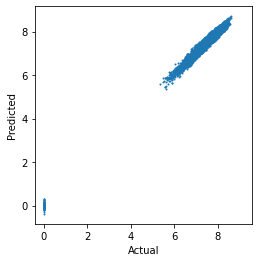

od_distance


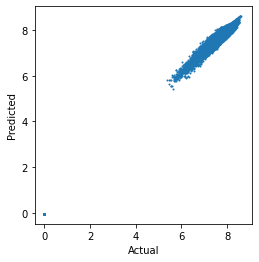

od_distance + class


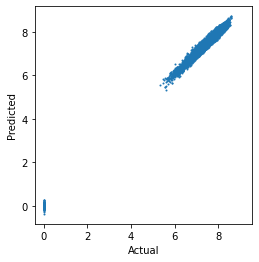

od_distance + node counts


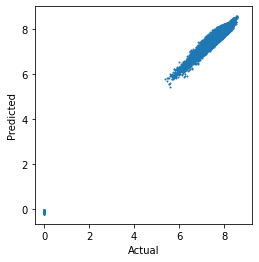

In [16]:
for variables,data, model in models:
    print(variables)
    y_pred = model.predict(data)
    plt.clf()
    plt.scatter(y,y_pred,s=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.axis('square')
    plt.savefig("../../../Gravity-model-for-econ-and-transport-networks/" + variables + "1.png")
    plt.show()

In [17]:
all_vars = ['Constant','od_distance_value', 'class_ART', 'class_BUS', 'class_COLL', 'class_FREE', 
                                                    'class_HWY', 'class_LOCL','class_SUBA', 'class_TRK2', 'class_TRK4',  
                                                    'class_UND', "road_counts",
                                                    'num_nodes_x', 'num_1degree_x', 'num_2degree_x', 
                                                    'num_3degree_x', 'num_4degree_x',
                                                   'num_greater5degree_x', 'num_nodes_y', 'num_1degree_y', 'num_2degree_y',
                                                   'num_3degree_y', 'num_4degree_y', 'num_greater5degree_y', 'Observations',
                                                   'R_squared', 'Adjusted_R_squared']


In [18]:
table1 = latex_table(all_vars,models)

In [19]:
table1.head(5)

,Constant,Constant_err,od_distance_value,od_distance_value_err,class_ART,class_ART_err,class_BUS,class_BUS_err,class_COLL,class_COLL_err,...,num_2degree_y_err,num_3degree_y,num_3degree_y_err,num_4degree_y,num_4degree_y_err,num_greater5degree_y,num_greater5degree_y_err,Observations,R_squared,Adjusted_R_squared
0,-0.143*,(0.069),0.719***,(0.001),0.031***,(0.002),0.022***,(0.001),0.137***,(0.006),...,(0.005),0.104***,(0.018),-0.015***,(0.003),0.004*,(0.002),10240.0,0.985,0.985
1,-0.05***,(0.013),0.751***,(0.001),,,,,,,...,,,,,,,,10240.0,0.973,0.973
2,-0.451***,(0.039),0.72***,(0.001),0.024***,(0.002),0.023***,(0.001),0.141***,(0.006),...,,,,,,,,10240.0,0.985,0.985
3,-0.088,(0.083),0.756***,(0.001),,,,,,,...,(0.007),0.022,(0.024),0.009*,(0.004),-0.002,(0.003),10240.0,0.973,0.973


In [20]:
table1.T.head(100)

,0,1,2,3
Constant,-0.143*,-0.05***,-0.451***,-0.088
Constant_err,(0.069),(0.013),(0.039),(0.083)
od_distance_value,0.719***,0.751***,0.72***,0.756***
od_distance_value_err,(0.001),(0.001),(0.001),(0.001)
class_ART,0.031***,,0.024***,
class_ART_err,(0.002),,(0.002),
class_BUS,0.022***,,0.023***,
class_BUS_err,(0.001),,(0.001),
class_COLL,0.137***,,0.141***,
class_COLL_err,(0.006),,(0.006),


In [21]:
print(table1.T.to_latex())

\begin{tabular}{lllll}
\toprule
{} &          0 &         1 &          2 &          3 \\
\midrule
Constant                 &    -0.143* &  -0.05*** &  -0.451*** &     -0.088 \\
Constant\_err             &    (0.069) &   (0.013) &    (0.039) &    (0.083) \\
od\_distance\_value        &   0.719*** &  0.751*** &    0.72*** &   0.756*** \\
od\_distance\_value\_err    &    (0.001) &   (0.001) &    (0.001) &    (0.001) \\
class\_ART                &   0.031*** &           &   0.024*** &            \\
class\_ART\_err            &    (0.002) &           &    (0.002) &            \\
class\_BUS                &   0.022*** &           &   0.023*** &            \\
class\_BUS\_err            &    (0.001) &           &    (0.001) &            \\
class\_COLL               &   0.137*** &           &   0.141*** &            \\
class\_COLL\_err           &    (0.006) &           &    (0.006) &            \\
class\_FREE               &  -0.008*** &           &  -0.007*** &            \\
class\_FREE\_err 

## Model 2 - Mobility Flow 

Gravity model:
$$ T_{ij} = \frac{T_i^{\alpha} T_j^{\beta}}{C_{ij}^{\gamma}}$$

Log-linear form:
$$ \log T_{ij} = \alpha \log T_i + \beta \log T_j - \gamma \log C_{ij} $$

Let us use basic economic info here.
1. $T_{ij}$ is the mobility flow from i to j.
2. $T_i$ and $T_j$ represent attractions, e.g. number of total jobs.
3. $C_{ij}$ represents frictions, e.g. travel time or other road attributes. Ideally, $C_{ij}$ can represent the actionable variables, such as road capacity/types. 

OLS can be used to estimate the three parameters $\alpha$, $\beta$, and $\gamma$.

More generally, we can write the gravity model as:
$$ \log T_{ij} = f_1(\log T_i, \log T_j; w_1) + f_2(\log C_{ij}; w_2) $$


In [22]:
edge_df_vars = np.array(['num_jobs_000_persons_origin', 'num_jobs_000_persons_destination',
                    'od_duration_value'])
_max = len(edge_df_vars)
print(_max)
indices = []
temp = [i for i in range(0,_max)]
for i in range(1,_max+1):
    poss = combination(temp, i)
    for elt in poss:
        indices.append(elt)
print(indices)

3
[[0], [1], [2], [0, 1], [0, 2], [1, 2], [0, 1, 2]]


In [23]:
best = 0
best_vars = None
best_model = None
for index in indices:
    curr_vars = edge_df_vars[index]
    print(curr_vars)
    # y
    y = np.log(edge_df['total_stays'])

    # X
    X = np.log(edge_df[curr_vars])

    X = sm.add_constant(X)

    
    # linear reg
    mod = sm.OLS(y, X)
    res = mod.fit()
    if res.rsquared > best:
        best = res.rsquared
        best_vars = curr_vars
        best_model = res
        print("New best RSQUARED:", best)
    
    print(res.rsquared)

['num_jobs_000_persons_origin']
New best RSQUARED: 0.061052503714691286
0.061052503714691286
['num_jobs_000_persons_destination']
New best RSQUARED: 0.06242015918604127
0.06242015918604127
['od_duration_value']
New best RSQUARED: 0.48081332898550966
0.48081332898550966
['num_jobs_000_persons_origin' 'num_jobs_000_persons_destination']
0.12796150814389184
['num_jobs_000_persons_origin' 'od_duration_value']
New best RSQUARED: 0.528833003375121
0.528833003375121
['num_jobs_000_persons_destination' 'od_duration_value']
0.5277485412246488
['num_jobs_000_persons_origin' 'num_jobs_000_persons_destination'
 'od_duration_value']
New best RSQUARED: 0.5794278271715446
0.5794278271715446


In [24]:
print("Highest rsquared:", best)
print("Vars used:", best_vars)
print("Best model summary:", best_model.summary())

Highest rsquared: 0.5794278271715446
Vars used: ['num_jobs_000_persons_origin' 'num_jobs_000_persons_destination'
 'od_duration_value']
Best model summary:                             OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4701.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:54:52   Log-Likelihood:                -15019.
No. Observations:               10240   AIC:                         3.005e+04
Df Residuals:                   10236   BIC:                         3.008e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err

In [25]:
models = []

In [26]:
# y
y = np.log(edge_df['total_stays'])
# y = np.log(edge_df['unique_agents'])

# X
X = np.log(edge_df[['num_jobs_000_persons_origin', 'num_jobs_000_persons_destination',
                    'od_duration_value']])

X = sm.add_constant(X)


In [27]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
models.append(("All", X, res))
print(res.summary())
print(res.rsquared)

                            OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4701.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:54:52   Log-Likelihood:                -15019.
No. Observations:               10240   AIC:                         3.005e+04
Df Residuals:                   10236   BIC:                         3.008e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

# Experiments for POI Count and Entropy

In [28]:
edge_poi_df =  pd.read_pickle('../../data_process/edge_degree_entropy_df.pickle')

In [29]:
edge_poi_df.head()

,timestamp,destination,state,origin,unique_agents,sum_stay_duration,total_stays,OD,class_ART,class_BUS,...,num_nodes_y,num_1degree_y,num_2degree_y,num_3degree_y,num_4degree_y,num_greater5degree_y,poi_entropy_x,poi_entropy_y,poi_count_x,poi_count_y
0,2018-02-01T00:00:00.000+11:00,401011001,4,401011001,19863,268779414,681217,401011001401011001,208.0,13.0,...,1642.0,291.0,199.0,865.0,276.0,11.0,2.487969,2.487969,3288.0,3288.0
1,2018-02-01T00:00:00.000+11:00,401011002,4,401011001,6911,4857456,29322,401011001401011002,267.0,16.0,...,517.0,149.0,54.0,239.0,69.0,6.0,2.487969,2.246419,3288.0,756.0
3,2018-02-01T00:00:00.000+11:00,401021004,4,401011001,1184,903377,5487,401011001401021004,430.0,13.0,...,2455.0,710.0,502.0,1126.0,110.0,7.0,2.487969,2.616117,3288.0,279.0
9,2018-02-01T00:00:00.000+11:00,401021010,4,401011001,685,347208,1897,401011001401021010,263.0,13.0,...,1854.0,535.0,360.0,911.0,46.0,2.0,2.487969,2.722838,3288.0,153.0
10,2018-02-01T00:00:00.000+11:00,401031011,4,401011001,2225,1664328,7709,401011001401031011,255.0,13.0,...,783.0,178.0,73.0,468.0,64.0,0.0,2.487969,2.472982,3288.0,276.0


In [30]:
# y
y = np.log(edge_poi_df['total_stays'])
# y = np.log(edge_df['unique_agents'])

# X
X = np.log(edge_poi_df[["poi_count_x","poi_count_y"]])

X = sm.add_constant(X)

In [31]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
models.append(("Poi Counts", X, res))
print(res.summary())
print(res.rsquared)

                            OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     573.2
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          8.97e-225
Time:                        17:54:54   Log-Likelihood:                -8793.3
No. Observations:                4983   AIC:                         1.759e+04
Df Residuals:                    4980   BIC:                         1.761e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9678      0.149     19.920      

In [32]:
# y
y = np.log(edge_poi_df['total_stays'])
# y = np.log(edge_df['unique_agents'])

# X
X = np.log(edge_poi_df[["poi_entropy_x","poi_entropy_y"]] + 1)

X = sm.add_constant(X)

In [33]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
models.append(("Poi Entropy", X, res))
print(res.summary())
print(res.rsquared)

                            OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     208.3
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.28e-87
Time:                        17:54:54   Log-Likelihood:                -9109.3
No. Observations:                4983   AIC:                         1.822e+04
Df Residuals:                    4980   BIC:                         1.824e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8354      0.166     29.206

In [34]:
# y
y = np.log(edge_poi_df['total_stays'])
# y = np.log(edge_df['unique_agents'])

# X
edge_poi_df[["poi_entropy_x","poi_entropy_y"]] = edge_poi_df[["poi_entropy_x","poi_entropy_y"]] + 1
X = np.log(edge_poi_df[["poi_count_x","poi_count_y","poi_entropy_x","poi_entropy_y"]])

X = sm.add_constant(X)

In [35]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
models.append(("Poi Counts + Entropy", X, res))
print(res.summary())
print(res.rsquared)

                            OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     299.4
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          4.22e-231
Time:                        17:54:55   Log-Likelihood:                -8772.3
No. Observations:                4983   AIC:                         1.755e+04
Df Residuals:                    4978   BIC:                         1.759e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0421      0.169     18.021

In [36]:
# y
y = np.log(edge_poi_df['total_stays'])
# y = np.log(edge_df['unique_agents'])

# X
edge_poi_df[["poi_entropy_x","poi_entropy_y"]] = edge_poi_df[["poi_entropy_x","poi_entropy_y"]] + 1
X = np.log(edge_poi_df[['num_jobs_000_persons_origin', 'num_jobs_000_persons_destination',
                    'od_duration_value',"poi_count_x","poi_count_y","poi_entropy_x","poi_entropy_y"]])

X = sm.add_constant(X)

In [37]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
models.append(("All with POI (less data)", X, res))
print(res.summary())
print(res.rsquared)

                            OLS Regression Results                            
Dep. Variable:            total_stays   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1296.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:54:55   Log-Likelihood:                -6722.9
No. Observations:                4983   AIC:                         1.346e+04
Df Residuals:                    4975   BIC:                         1.351e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [38]:
all_vars = ['Constant','num_jobs_000_persons_origin', 'num_jobs_000_persons_destination', 'od_duration_value',
           "poi_count_x","poi_count_y","poi_entropy_x","poi_entropy_y"]

In [39]:
table2 = latex_table(all_vars,models)
table2.head()

,Constant,Constant_err,num_jobs_000_persons_origin,num_jobs_000_persons_origin_err,num_jobs_000_persons_destination,num_jobs_000_persons_destination_err,od_duration_value,od_duration_value_err,poi_count_x,poi_count_x_err,poi_count_y,poi_count_y_err,poi_entropy_x,poi_entropy_x_err,poi_entropy_y,poi_entropy_y_err,Adjusted_R_squared,Observations,R_squared
0,13.276***,(0.105),0.755***,(0.021),0.56***,(0.016),-1.189***,(0.011),,,,,,,,,0.579,10240.0,0.579
1,2.968***,(0.149),,,,,,,0.331***,(0.02),0.59***,(0.02),,,,,0.187,4983.0,0.187
2,4.835***,(0.166),,,,,,,,,,,0.6***,(0.107),2.119***,(0.108),0.077,4983.0,0.077
3,3.042***,(0.169),,,,,,,0.414***,(0.025),0.532***,(0.025),-0.678***,(0.127),0.487***,(0.128),0.193,4983.0,0.194
4,9.574***,(0.22),0.883***,(0.037),0.473***,(0.036),-1.007***,(0.013),0.095***,(0.02),0.319***,(0.02),-0.791***,(0.118),0.966***,(0.118),0.645,4983.0,0.646


In [40]:
table2.T.head(100)

,0,1,2,3,4
Constant,13.276***,2.968***,4.835***,3.042***,9.574***
Constant_err,(0.105),(0.149),(0.166),(0.169),(0.22)
num_jobs_000_persons_origin,0.755***,,,,0.883***
num_jobs_000_persons_origin_err,(0.021),,,,(0.037)
num_jobs_000_persons_destination,0.56***,,,,0.473***
num_jobs_000_persons_destination_err,(0.016),,,,(0.036)
od_duration_value,-1.189***,,,,-1.007***
od_duration_value_err,(0.011),,,,(0.013)
poi_count_x,,0.331***,,0.414***,0.095***
poi_count_x_err,,(0.02),,(0.025),(0.02)


In [41]:
print(table2.T.to_latex())

\begin{tabular}{llllll}
\toprule
{} &          0 &         1 &         2 &          3 &          4 \\
\midrule
Constant                             &  13.276*** &  2.968*** &  4.835*** &   3.042*** &   9.574*** \\
Constant\_err                         &    (0.105) &   (0.149) &   (0.166) &    (0.169) &     (0.22) \\
num\_jobs\_000\_persons\_origin          &   0.755*** &           &           &            &   0.883*** \\
num\_jobs\_000\_persons\_origin\_err      &    (0.021) &           &           &            &    (0.037) \\
num\_jobs\_000\_persons\_destination     &    0.56*** &           &           &            &   0.473*** \\
num\_jobs\_000\_persons\_destination\_err &    (0.016) &           &           &            &    (0.036) \\
od\_duration\_value                    &  -1.189*** &           &           &            &  -1.007*** \\
od\_duration\_value\_err                &    (0.011) &           &           &            &    (0.013) \\
poi\_count\_x                          & 

Poi Counts


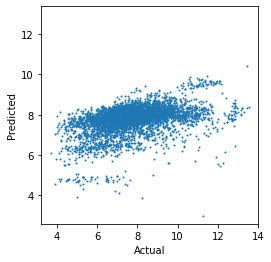

Poi Entropy


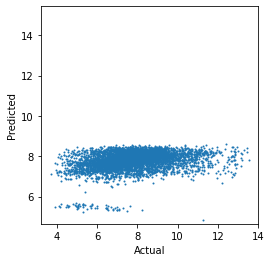

Poi Counts + Entropy


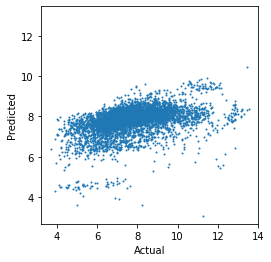

All with POI (less data)


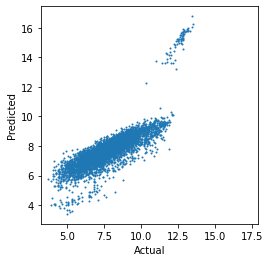

In [42]:
for variables,data, model in models[1:]:
    print(variables)
    y_pred = model.predict(data)
    plt.clf()
    plt.scatter(y,y_pred,s=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.axis('square')
    plt.savefig("../../../Gravity-model-for-econ-and-transport-networks/" + variables + "2.png")
    plt.show()

## Model 3 - Economic Growth

In [43]:
print(node_df.columns)

Index(['SA2_MAIN16', 'SA2_5DIG16', 'SA2_NAME16', 'SA3_CODE16', 'SA3_NAME16',
       'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'GCC_NAME16', 'STE_CODE16',
       'STE_NAME16', 'AREASQKM16', 'class_ART', 'class_BUS', 'class_COLL',
       'class_FREE', 'class_HWY', 'class_LOCL', 'class_SUBA', 'class_TRK2',
       'class_TRK4', 'class_UND', 'geometry', 'num_jobs_000_persons',
       'sa2_code16', 'median_income_per_job_aud_persons', 'origin_x',
       'unique_agents_origin_counts', 'sum_stay_duration_origin_counts',
       'total_stays_origin_counts', 'destination_x',
       'unique_agents_destination_counts',
       'sum_stay_duration_destination_counts',
       'total_stays_destination_counts', 'origin_y',
       'unique_agents_origin_entropy', 'sum_stay_duration_origin_entropy',
       'total_stays_origin_entropy', 'destination_y',
       'unique_agents_destination_entropy',
       'sum_stay_duration_destination_entropy',
       'total_stays_destination_entropy'],
      dtype='object')


In [44]:
# var list
# var_list = ['unique_agents_origin_counts', 'unique_agents_destination_counts',
#             'unique_agents_origin_entropy', 'unique_agents_destination_entropy']

# var_list = ['sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
#             'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy']

var_list = ['total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy']


In [45]:
# y
y = np.log(node_df['median_income_per_job_aud_persons'])

# X
X = np.log(node_df[var_list])

X = sm.add_constant(X)


In [46]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                                    OLS Regression Results                                   
Dep. Variable:     median_income_per_job_aud_persons   R-squared:                       0.441
Model:                                           OLS   Adj. R-squared:                  0.419
Method:                                Least Squares   F-statistic:                     19.35
Date:                               Fri, 09 Apr 2021   Prob (F-statistic):           9.25e-12
Time:                                       18:01:18   Log-Likelihood:                 105.08
No. Observations:                                103   AIC:                            -200.2
Df Residuals:                                     98   BIC:                            -187.0
Df Model:                                          4                                         
Covariance Type:                           nonrobust                                         
                                      coef    std err       

In [47]:
# var list
var_list = ['unique_agents_origin_counts', 'unique_agents_destination_counts',
            'unique_agents_origin_entropy', 'unique_agents_destination_entropy',
            'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
            'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy',
            'total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy']


In [48]:
var_list = np.array(['unique_agents_origin_counts', 'unique_agents_destination_counts',
            'unique_agents_origin_entropy', 'unique_agents_destination_entropy',
            'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
            'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy',
            'total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy'])
_max = len(var_list)
print(_max)
indices = []
temp = [i for i in range(0,_max)]
for i in range(1,_max+1):
    poss = combination(temp, i)
    for elt in poss:
        indices.append(elt)
print(indices)

12
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5], [0, 1, 6], [0, 1, 7], [0, 1, 8], [0, 1, 9], [0, 1, 10], [0, 1, 11], [0, 2, 3], [0, 2, 4], [0, 2, 5], [0, 2, 6], [0, 2, 7], [0, 2, 8], [0, 2, 9], [0, 2, 10], [0, 2, 11], [0, 3, 4], [0, 3, 5], [0, 3, 6], [0, 3, 7], [0, 3, 8], [0, 3, 9], [0, 3, 10], [0, 3, 11], [0, 4, 5], [0, 4, 6], [0, 4, 7], [0, 4, 8], [0, 4, 9], [0, 4, 10], [0, 4, 11], [0

In [49]:
best = 0
best_vars = None
best_model = None
for index in indices:
    curr_vars = var_list[index]
    print(curr_vars)
    # y
    y = np.log(node_df['median_income_per_job_aud_persons'])

    # X
    X = np.log(node_df[curr_vars])

    X = sm.add_constant(X)

    
    # linear reg
    mod = sm.OLS(y, X)
    res = mod.fit()
    if res.rsquared > best:
        best = res.rsquared
        best_vars = curr_vars
        best_model = res
        print("New best RSQUARED:", best)
    
    print(res.rsquared)

['unique_agents_origin_counts']
New best RSQUARED: 0.015074885363259627
0.015074885363259627
['unique_agents_destination_counts']
New best RSQUARED: 0.10887612723044149
0.10887612723044149
['unique_agents_origin_entropy']
0.014813846296319433
['unique_agents_destination_entropy']
New best RSQUARED: 0.16995274736120636
0.16995274736120636
['sum_stay_duration_origin_counts']
0.0010601645233210277
['sum_stay_duration_destination_counts']
0.02893996424037537
['sum_stay_duration_origin_entropy']
0.02685154737262685
['sum_stay_duration_destination_entropy']
New best RSQUARED: 0.1806357848584873
0.1806357848584873
['total_stays_origin_counts']
0.0007395775937001359
['total_stays_destination_counts']
0.1044489391624156
['total_stays_origin_entropy']
0.10581935920227126
['total_stays_destination_entropy']
0.17142701096370094
['unique_agents_origin_counts' 'unique_agents_destination_counts']
New best RSQUARED: 0.3533303260707914
0.3533303260707914
['unique_agents_origin_counts' 'unique_agents_or

0.3718424345199307
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_destination_counts']
0.4568120758052806
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_origin_entropy']
0.3082997656467886
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'total_stays_destination_entropy']
0.24205138346785415
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts']
0.3828842521548623
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy']
0.20594764854084024
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy']
0.40238508303724496
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts']
0.20907673681536487
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'total_stays_destination_counts']
0.44350501776677387
['unique_ag

0.4206655457931987
['unique_agents_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.18399823441404417
['unique_agents_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.3865164358283384
['unique_agents_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4115637215694383
['unique_agents_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.26657448844916676
['unique_agents_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.3043381159991385
['unique_agents_destination_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.3013797670178894
['unique_agents_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.41171205306333847
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts']
0.2325241437274137
['unique_a

0.3850838128231251
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.02956625184708217
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts']
0.38664360480659776
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy']
0.1731489859205253
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_entropy']
0.335196650859345
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts']
0.18425033337230923
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts']
0.37654869439586325
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_entropy']
0.41895848804171965
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_entropy']


0.4292696440693725
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy']
0.43046848997211584
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'total_stays_origin_counts']
New best RSQUARED: 0.46689199571316853
0.46689199571316853
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'total_stays_destination_counts']
0.46046224984977135
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'total_stays_origin_entropy']
0.44146054086858977
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'total_stays_destination_entropy']
0.43078293421598945
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy']
0.4382961154772499
['uniqu

0.4570327036808053
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy']
0.3396263159778492
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_entropy']
0.3425725584773406
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.4465249747450528
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4568186373470078
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4278300639410261
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.2940189970788133
['unique_agents_origin_counts' 'uniq

0.4527942909664785
['unique_agents_origin_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4727159699766952
['unique_agents_origin_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.44939169390101286
['unique_agents_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.45646117875696135
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts']
0.30480412555972125
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts']
0.24032851050092896
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy']
0.2653565263019919
['unique_agents_destination_counts' 'unique_agents_origin_

0.3984977615914541
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy']
0.4135695598629875
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_entropy']
0.3632508392670041
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.2627714006490871
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.3774317717043295
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4272219480269337
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.2821255651245089
['unique_agents_de

0.30397331853233855
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.2482058650545489
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.31412134744988063
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.2771825669811101
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4147455175816429
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy']
0.34527472153185124
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.3621103146326684
['unique_agents_origin_entropy' 'sum_sta

0.3914320145006084
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.41480681156156685
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.3861324463815117
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.3370694548783114
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts']
0.35028188104680424
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy']
0.3310121417099633
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_entropy']
0.331227944594

0.44206504621096654
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.3895657112056157
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4090443994310662
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4209243050666187
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.385274665124515
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.3959009127968167
['sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.20615209081350283
['sum_stay_duration_origin_count

0.3788514683555172
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_origin_counts']
0.46424200655836156
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_counts']
0.46403025825113386
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_origin_entropy']
0.4326822261961606
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_entropy']
0.4077122867859635
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts']
0.44626896305993846
['unique_agents_origin_counts' 'unique_age

0.4337680125740597
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.46922517609959613
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts']
0.4651978232862546
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy']
0.45023246464427247
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_entropy']
0.43081047763803515
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts']
0.4706540527288463
['unique_agents_origin_counts' 'uniq

0.3913299903949844
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_destination_counts']
0.470104939994733
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_entropy']
0.36379873970743026
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_destination_entropy']
0.4043815778866451
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy']
0.4581659702250469
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.4537135695112873
['unique_agents_origin_counts

New best RSQUARED: 0.48470790404823005
0.48470790404823005
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.44296141682254786
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4538583023720155
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.45627249090200517
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.4447124610028427
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4478930001734161

0.45856313830823436
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.4542349549134196
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4576278468595252
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.428259863437334
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4013342130021744
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.47530680102710343
['unique_agents

0.4573347337303748
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.45013643041169904
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4752391561593303
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4682493868930818
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.46837713400585335
['unique_agents_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.48470691408192357
['unique_agents_or

0.3834680530103002
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4260028072975788
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.30363922141626
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4350892544910906
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.41180004645242474
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.31444635264933685
['unique_agents_destination_count

['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.39354867365233137
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.42189811618392625
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.3873681793749626
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.40837059756266136
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4210488248422778
['unique_agents_destination_counts' 'unique

0.330362012422863
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.3542465883958891
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4289356829820554
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.2538550066317149
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.41197404376464963
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0

0.3932030073245756
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.40912344125622047
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.42745734707785776
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.3936647213020963
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.40118707290397726
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4213973676371918
['unique_

0.422148981425308
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.3913154789214446
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.42543381661854673
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.44269592961124593
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4031166570999287
['unique_agents_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4242701394080375
['unique_agents_destination_c

0.3911893066704918
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.3918848986363094
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4264393367896333
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.40009024816492456
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4263559600204483
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.3366607982656762
['unique_agents_origi

0.2355308576986176
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.43373154701452254
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4189619874613856
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.42545658890893334
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4213400782618554
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.41468376335353796
['unique_agents_origin_entropy' 'sum_stay

0.3666870254173915
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.39286980299149865
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4443896352513673
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.37167032330780536
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.3989015912269894
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.41

0.4183701852440411
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4115078817725363
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.42724684198591845
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.39627965285683364
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4265582126685664
['unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.39317137137753355

0.4273126555690592
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.43831249211220136
['sum_stay_duration_origin_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4414195273758743
['sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.41173935977247955
['sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4434380219519036
['sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.3849116708479349
['sum_stay_dur

0.46694672725566655
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.46490726677339067
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4640330559144682
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.46407566915978793
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.43315929779983897
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_

0.469449201713412
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.4648332243356327
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.45864539880816335
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.45252377217051154
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.436456305050387
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_dur

0.48697066818157997
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4633126465337494
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4622786260180375
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.45904566966326066
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.4660451373950255
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 '

0.47038753077414264
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.466357834739367
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4505765999819429
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.47527309156027486
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.47299070942368093
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_

0.47457979170946973
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy']
0.469930677857909
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy']
0.4618178649061725
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts']
0.4673679158255175
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts']
0.4702697762432382
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_a

0.4761549262177581
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4475294568650968
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.44986602924368524
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.464832458319691
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.46597087220233924
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destinatio

0.45936766032151477
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4313667432889179
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4625950124075432
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.45533618961964484
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.4882188069789296
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination

0.4720474291829231
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4730982649649702
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.4939556778943951
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.48696947409470726
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4718559933573365
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_ori

0.494927976972397
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.48781232679686626
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.46756494787175906
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.46534149621919874
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4659648270552633
['unique_agents_origin_counts' 'unique_agents_des

0.4559759229634479
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4629827053487525
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4663904639844595
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4677348102697908
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44405376514062644
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_sta

0.43329203236500424
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.42876491424096896
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.3529965484297799
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4373091112981624
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.4140524129954758
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents

0.41929719857957204
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy']
0.4401954448790999
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_entropy']
0.39913299347690534
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.38850638384011127
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4124515870045655
['unique_agents_destination_counts' 'unique_agents_origi

0.3817544496364853
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4296100560004953
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4321813605146333
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4137352348303941
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.43432654402589277
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_d

0.4088737845541317
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4216765447521783
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.4138897934051651
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.43273892079973353
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.3303710334819383
['unique_agents_destination_counts' 'unique_agents_destination_entropy

0.4126650359257912
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.42440267860003045
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4305126524059425
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.44814777949814977
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4171948536160913
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_sta

0.42326384869672673
['unique_agents_destination_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.40603196770777894
['unique_agents_destination_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.43053644763498766
['unique_agents_destination_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4498128027895433
['unique_agents_destination_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4078510139758412
['unique_agents_destination_counts' 'sum_stay_duratio

0.431932831124219
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.307948005735704
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4435276857221674
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.43062581334724037
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_entropy'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4265478596491795
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'su

['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4183022800795243
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4494350846999001
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4380214897994614
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.42703644127432605
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_entropy' 'to

0.4214364127396488
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.44447434791076645
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.3876011490046829
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4236848324578284
['unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.41285641726105526
['unique_agents_origin_entropy' 'sum_stay_duration_dest

0.39635415268397145
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4384133630843223
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.41545151990837825
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4268349939665864
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4603902903588424
['unique_agents_destination_entropy' 'sum_stay_duration_origin

0.4572294239249207
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.44220960482694427
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.40754056793028703
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4592537053038793
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.45412108749849034
['sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_st

0.47154071073794157
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4727667045561542
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4721340568195297
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44480834249161894
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_st

0.4640916180489235
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy']
0.44849301116239404
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts']
0.4849835088400003
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts']
0.46533113962258843
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_ori

0.48831150032777937
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4708115291301407
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.45403869121108276
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.47611453935319337
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts

0.4691313153102399
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4733857009361826
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4810637126617363
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4963121238511997
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origi

0.4956643278928148
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.48703681645731767
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4956535416229956
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.46459772453551984
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts

0.474370455246685
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.471059035506332
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4703886589147014
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.46775581579029957
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_

0.4753396377044635
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.46968713153402264
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4725427858507685
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.47386535436633714
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_

0.4662756904794416
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4954289861062485
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.48711981577366303
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.49599513987190236
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destinat

0.4677348736460999
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4533495647626685
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4655902686368206
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.48117577500013153
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.46

0.48827444142067444
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.47549123914660096
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.48097748256469486
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.47313414430473066
['unique_agents_origin_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'total_stays_origin_counts' 'total

0.4698611325828054
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4984470313102809
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.46727653332589847
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.46781966370254524
['unique_agents_origin_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' '

0.43560206449585426
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.42891318437338743
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.4085678993740881
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.4377335801637938
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_ori

0.41272289021999653
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4265305516271758
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4580435115333302
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.43677527555414
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_

0.4423273538311028
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_origin_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.44454320534238356
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.421440071767036
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4500151430992936
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_coun

0.43376493750562506
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4013589014808461
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4386857138335184
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.41629321767084015
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_en

0.45547068441649696
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4417326053879671
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.3931248072927205
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4442096899922705
['unique_agents_destination_counts' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'to

0.4018420295550126
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4438286737883119
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.43404112368885817
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4268456198030359
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destinat

0.45962024202721874
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4543679851088581
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.44103621580032704
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4196536376508586
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_ent

0.46137466693791296
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4496174404361529
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4727007548429528
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4227090194001001
['unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_

0.47680802239320064
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_entropy']
0.474738906541462
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.49218979950984554
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.49261503887556357
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_

0.4791692663561743
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.4715925782287692
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4661566121489247
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4710239918316339
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'uniqu

0.47833516633794393
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.475212884787377
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.4736075045568571
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.471614561584612
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'sum_stay_dur

0.5025170988025645
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_entropy']
0.48446202038228314
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts']
0.5055469456238255
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy']
0.505640992469912
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destinat

0.4982871031363926
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4730935555282031
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.5008854606627471
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.5032735586952903
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents

0.48968593257956305
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4891629832508382
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4904959110144266
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4766389830813944
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_du

0.5065274104378055
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.49794910894520206
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.4810562652157604
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4988175879386476
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_de

0.4821209892612356
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4693918488126304
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.49872713815484604
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4992384013828307
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'sum_stay_duration_destination_counts' 'sum_

0.499209433828135
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts']
0.4173938166196107
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts']
0.4362211875236339
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_entropy']
0.4565092614214049
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'u

0.4751695609815172
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4316745639149596
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.45273534861326636
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4411348767032728
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_des

0.4748019570859171
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.40466832814757336
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.4526359043868804
['unique_agents_destination_counts' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.41635680316841817
['unique_agents_destination_counts' 'unique_agents_desti

0.4587155246895027
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4505563682272947
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.4384382408784545
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4479852769696542
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origi

0.48473586780182065
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts']
0.5056376968841525
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy']
0.5059234106950538
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy' 'total_stays_origin_counts'
 'total_stays_destination_entropy']
0.5059435164438542
['uni

0.4881024719931478
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4963681515152084
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4704260889709737
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.49636640094720696
[

0.5029778132874069
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_origin_entropy']
0.5057094510102094
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_destination_counts'
 'total_stays_destination_entropy']
0.5059662014181313
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'total_stays_origin_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.5059546194420281
['u

0.4964374789334782
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.48229718455463155
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4965053572423417
['unique_agents_origin_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.49371201302873113
['unique

0.4614836848940641
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy']
0.4527402649012887
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_destination_entropy']
0.44125434963471155
['unique_agents_destination_counts' 'unique_agents_origin_entropy'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.4

0.46275973460461817
['unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.47289690387222705
['unique_agents_origin_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.46666196567394247
['unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
0.4728

0.507490438553089
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
New best RSQUARED: 0.5082001314402729
0.5082001314402729
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_destination_counts'
 'total_stays_origin_entropy' 'total_stays_destination_entropy']
0.5043121710366092
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_destination_entropy' 'sum_stay_duration_origin_counts'
 'sum_stay_duration_destination_counts' 'sum_stay_duration_origin_entrop

0.47929563308422274
['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
New best RSQUARED: 0.5083186248331018
0.5083186248331018


In [50]:
print("Highest rsquared:", best)
print("Vars used:", best_vars)
print("Best model summary:", best_model.summary())

Highest rsquared: 0.5083186248331018
Vars used: ['unique_agents_origin_counts' 'unique_agents_destination_counts'
 'unique_agents_origin_entropy' 'unique_agents_destination_entropy'
 'sum_stay_duration_origin_counts' 'sum_stay_duration_destination_counts'
 'sum_stay_duration_origin_entropy'
 'sum_stay_duration_destination_entropy' 'total_stays_origin_counts'
 'total_stays_destination_counts' 'total_stays_origin_entropy'
 'total_stays_destination_entropy']
Best model summary:                                     OLS Regression Results                                   
Dep. Variable:     median_income_per_job_aud_persons   R-squared:                       0.508
Model:                                           OLS   Adj. R-squared:                  0.443
Method:                                Least Squares   F-statistic:                     7.754
Date:                               Fri, 09 Apr 2021   Prob (F-statistic):           1.07e-09
Time:                                       18:01:

In [51]:
# y
y = np.log(node_df['median_income_per_job_aud_persons'])

# X
X = np.log(node_df[var_list])

X = sm.add_constant(X)


In [52]:
# linear reg
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

print(res.rsquared)

                                    OLS Regression Results                                   
Dep. Variable:     median_income_per_job_aud_persons   R-squared:                       0.508
Model:                                           OLS   Adj. R-squared:                  0.443
Method:                                Least Squares   F-statistic:                     7.754
Date:                               Fri, 09 Apr 2021   Prob (F-statistic):           1.07e-09
Time:                                       18:01:38   Log-Likelihood:                 111.66
No. Observations:                                103   AIC:                            -197.3
Df Residuals:                                     90   BIC:                            -163.1
Df Model:                                         12                                         
Covariance Type:                           nonrobust                                         
                                            coef    std err 

In [53]:
all_vars = ['Constant','unique_agents_origin_counts', 'unique_agents_destination_counts',
            'unique_agents_origin_entropy', 'unique_agents_destination_entropy',
            'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts',
            'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy',
            'total_stays_origin_counts', 'total_stays_destination_counts',
            'total_stays_origin_entropy', 'total_stays_destination_entropy']
errors = []
for elt in all_vars:
    e = elt + "_err"
    errors.append(e)
temp = []
for i in range(len(all_vars)):
    temp.append(all_vars[i])
    if all_vars[i] not in {'Observations','R_squared', 'Adjusted_R_squared'}:
        temp.append(errors[i])

print(all_vars)
print(temp)

['Constant', 'unique_agents_origin_counts', 'unique_agents_destination_counts', 'unique_agents_origin_entropy', 'unique_agents_destination_entropy', 'sum_stay_duration_origin_counts', 'sum_stay_duration_destination_counts', 'sum_stay_duration_origin_entropy', 'sum_stay_duration_destination_entropy', 'total_stays_origin_counts', 'total_stays_destination_counts', 'total_stays_origin_entropy', 'total_stays_destination_entropy']
['Constant', 'Constant_err', 'unique_agents_origin_counts', 'unique_agents_origin_counts_err', 'unique_agents_destination_counts', 'unique_agents_destination_counts_err', 'unique_agents_origin_entropy', 'unique_agents_origin_entropy_err', 'unique_agents_destination_entropy', 'unique_agents_destination_entropy_err', 'sum_stay_duration_origin_counts', 'sum_stay_duration_origin_counts_err', 'sum_stay_duration_destination_counts', 'sum_stay_duration_destination_counts_err', 'sum_stay_duration_origin_entropy', 'sum_stay_duration_origin_entropy_err', 'sum_stay_duration_d

In [54]:
table1 = pd.DataFrame(columns=temp)
models = [("All",X,res)]
for variables,data, model in models:
    dict = {}
    for i, elt in enumerate(all_vars):
        if elt in model.params:
            i = list(model.params.keys()).index(elt)
            pval = model.pvalues[i]
            tag = ""
            if pval < 0.001:
                tag = "***"
            elif pval < 0.01:
                tag = "**"
            elif pval < 0.05:
                tag = "*"
            dict[elt] = str(round(model.params[elt], 3)) + tag
            dict[elt+"_err"] = "(" + str(round(model.bse[elt], 3)) + ")"
        else:
            dict[elt] = "" 
            if elt not in {'Observations', 'R_squared', 'Adjusted_R_squared'}:
                dict[elt+"_err"] = ""
    dict["Observations"] = model.nobs
    dict["R_squared"] = round(model.rsquared,3)
    dict["Adjusted_R_squared"] = round(model.rsquared_adj,3)
    i = list(model.params.keys()).index("const")
    pval = model.pvalues[i]
    tag = ""
    if pval < 0.001:
        tag = "***"
    elif pval < 0.01:
        tag = "**"
    elif pval < 0.05:
        tag = "*"
    dict["Constant"] = str(round(model.params["const"],3)) + tag
    dict["Constant_err"] = "(" + str(round(model.bse["const"], 3)) + ")"
    
    table1 = table1.append(dict, ignore_index=True)

In [55]:
table1.T.head(100)

,0
Constant,13.658***
Constant_err,(1.641)
unique_agents_origin_counts,0.594*
unique_agents_origin_counts_err,(0.258)
unique_agents_destination_counts,0.031
unique_agents_destination_counts_err,(0.106)
unique_agents_origin_entropy,-0.089
unique_agents_origin_entropy_err,(0.611)
unique_agents_destination_entropy,-0.405
unique_agents_destination_entropy_err,(0.34)


In [56]:
print(table1.T.to_latex())

\begin{tabular}{ll}
\toprule
{} &          0 \\
\midrule
Constant                                  &  13.658*** \\
Constant\_err                              &    (1.641) \\
unique\_agents\_origin\_counts               &     0.594* \\
unique\_agents\_origin\_counts\_err           &    (0.258) \\
unique\_agents\_destination\_counts          &      0.031 \\
unique\_agents\_destination\_counts\_err      &    (0.106) \\
unique\_agents\_origin\_entropy              &     -0.089 \\
unique\_agents\_origin\_entropy\_err          &    (0.611) \\
unique\_agents\_destination\_entropy         &     -0.405 \\
unique\_agents\_destination\_entropy\_err     &     (0.34) \\
sum\_stay\_duration\_origin\_counts           &     -0.069 \\
sum\_stay\_duration\_origin\_counts\_err       &    (0.213) \\
sum\_stay\_duration\_destination\_counts      &     -0.272 \\
sum\_stay\_duration\_destination\_counts\_err  &    (0.178) \\
sum\_stay\_duration\_origin\_entropy          &     -0.418 \\
sum\_stay\_duration\_o

All


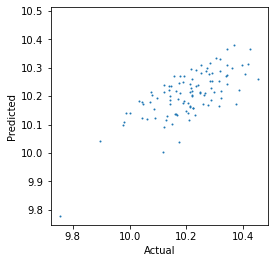

In [57]:
for variables,data, model in models:
    print(variables)
    y_pred = model.predict(data)
    plt.clf()
    plt.scatter(y,y_pred,s=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.axis('square')
    plt.savefig("../../../Gravity-model-for-econ-and-transport-networks/" + variables + "3.png")
    plt.show()

In [58]:
node_df.shape

(103, 42)